<a href="https://colab.research.google.com/github/tarod13/OptimalControl/blob/main/OptimalControl_DP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Programming project

First, we'll load the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Methods

### 1.1 Trajectory simulations
We need to defined methods that allow simulating trajectories based on the differential equation $\dot{x}(t)=Ax(t)+Bu(t)$ that specify the system being controlled.

We will use the Dormand-Prince method to simulate the dynamics. For this, we will define an integration step method that receives as input the state-action pair $(x(t),u(t))$ and approximates the corresponding adjusted derivative $\frac{dx}{dt}$. Then, we introduce a second method that executes several times the step, to produce a trajectory where $x[k+1]\leftarrow x[k]+\frac{dx}{dt}\Delta t$.   

In [2]:
# Dormand-Prince integration step
def step_DormandPrince(f,t,x,h,u,f_args):

    k1 = f(t,x,u,f_args)
    x2 = x + h*(1./5.*k1)
    k2 = f(t + 1./5.*h, x2, u, f_args)
    x3 = x + h*(3./40.*k1 + 9./40.*k2)
    k3 = f(t + 3./10*h, x3, u, f_args)
    x4 = x + h*(44./45.*k1 - 56./15.*k2 + 32./9.*k3)
    k4 = f(t + 4./5.*h, x4, u, f_args)
    x5 = x + h*(19372./6561.*k1 - 25360./2187.*k2 + 64448./6561.*k3 - 212./729.*k4)
    k5 = f(t + 8./9.*h, x5, u, f_args)
    x6 = x + h*(9017./3168.*k1 - 355./33.*k2 + 46732./5247.*k3 + 49./176.*k4 - 5103./18656.*k5)
    k6 = f(t + h, x6, u, f_args)

    dx_dt = 35./384.*k1 + 500./1113.*k3 + 125./192.*k4 - 2187./6784.*k5 + 11./84.*k6    
    return dx_dt

In [3]:
# Dormand-Prince simulation with forced input
def simulate_trajectory_DormandPrince(f, t, x0, f_args):
    N = len(t)
    x = [x0]
    u0 = x2u(x0)
    u = [u0]    
    for k in range(0, N-1):
        dx_dt = step_DormandPrince(f,t[k],x[k],t[k+1]-t[k],u[k],f_args)
        dt = t[k+1]-t[k]
        x.append(x[k] + dx_dt*dt)
        u.append(x2u(x[k+1]))
    return np.stack(x), np.stack(u)

In [4]:
# Define system dynamics
def system_ode(t, x, u, args):
  A = args['A']; B = args['B']
  xdot = np.einsum('ij,kj->ki',A,x) + np.einsum('ij,kj->ki',B,u)  
  return xdot

### 1.2 Conversion methods and initial policy
We need to discretize the states to apply the tabular version of the DP algortihms. Also, to control the system from the policy we will need to convert discrete actions into control signals. 

In [5]:
# State in original coordinates to DP discrete state
def x2s(x, x_min=-1.0, x_max=1.0, NS=101):
  x_clip = x.clip(x_min, x_max)
  x_unit = (x_clip - x_min) / (x_max-x_min)
  s_float = x_unit * NS
  s = np.floor(s_float).astype('int')
  return s  

In [6]:
# Action taken by initial policy
def simple_policy(state, NS=101, NA=11):
  s_0 = (NS-1)//2
  a_0 = (NA-1)//2
  if state[0] == s_0 and state[1] == s_0:
    return a_0
  elif state[0] > s_0 and state[1] >= s_0:
    return 0
  elif state[0] >= s_0 and state[1] < s_0:
    return a_0+2
  elif state[0] < s_0 and state[1] <= s_0:
    return NA-1
  elif state[0] <= s_0 and state[1] > s_0:
    return a_0-2
  else:
    print(state[0], state[1])
    raise NameError('Invalid state')

In [7]:
# Initial policy that takes state to origin
def s2a_simple_policy(s, NS=101):
  n_s = s.shape[0]
  a_list = [simple_policy(state) for state in s.tolist()]
  a = np.array(a_list).reshape(-1,1)
  return a

In [8]:
# DP discrete action to control signal 
def a2u(a, u_min=-1.0, u_max=1.0, NA=11):
  a_unit = a.astype('float') / float(NA-1)
  u = a_unit * (u_max-u_min) + u_min
  return u

In [9]:
# State to control signal
def x2u(x, policy='simple'):
  s = x2s(x)
  if policy == 'simple':
    a = s2a_simple_policy(s)
  else:
    raise NameError('undefined policy')
  u = a2u(a)
  return u

In [10]:
# Initialize J table
def init_J(NS=101):
  J = np.zeros((NS,NS))
  J[0,:] = np.infty
  J[-1,:] = np.infty
  J[:,0] = np.infty
  J[:,-1] = np.infty
  return J.copy()

## 2. Initial simulation with simple policy
We test our methods simulating three different initial conditions, with 2 different timesteps.

In [11]:
x0 = np.array([[0.5, 0.83], [-0.5, -0.83], [0.45, -0.1]])
A = np.array([[0.0,1.0],[0.0,0.0]])
B = np.array([[0.0],[1.0]])
ode_args = {'A': A.copy(), 'B': B.copy()}

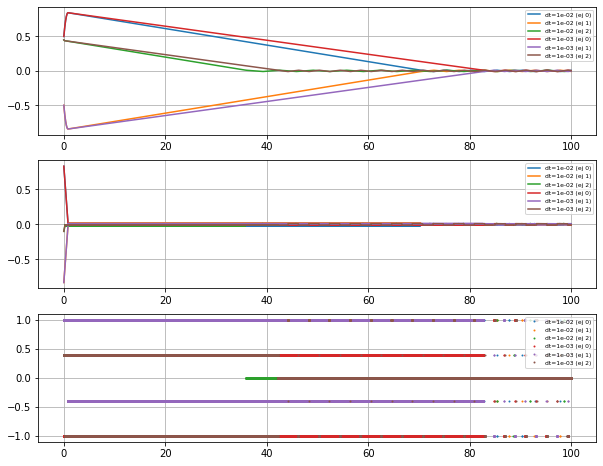

In [12]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
for dt in [0.01, 0.001]:
    t = np.arange(0,100,dt);
    x, u = simulate_trajectory_DormandPrince(system_ode,t,x0,ode_args)
    for i in range(0, x0.shape[0]): 
      label_ = "dt=%.0e"%dt+" (ej "+str(i)+")"   
      ax[0].plot(t, x[:,i,0], '-', ms=1, label=label_);
      ax[1].plot(t, x[:,i,1], '-', ms=1, label=label_);
      ax[2].plot(t, u[:,i], 'o', ms=1, label=label_);
for i in range(0,3):
  ax[i].grid()
  ax[i].legend(fontsize=6)
plt.show()
plt.close() 

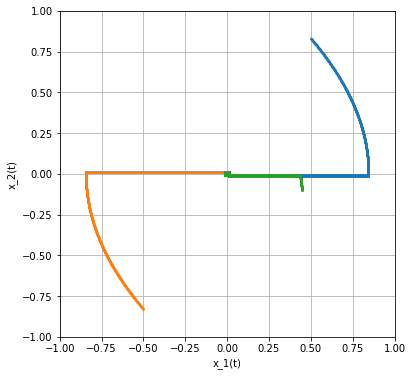

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
for i in range(0, x0.shape[0]): 
  ax.plot(x[:,i,0], x[:,i,1], 'o', ms=1);
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel(r'x_1(t)')
plt.ylabel(r'x_2(t)')
plt.grid() 
plt.show()
plt.close() 

We can see that in all the cases the initial policy is successful in changing the state of the system to the origin. Also, it seems that precision is not heavily affected by increasing the time step $\Delta t$ from $0.001$ to $0.01$. Thus, we will fix this hyperparameter to 0.01.

In [14]:
NS = 103
J = init_J(NS)